In [1]:
# functions for post-processing
%run tools.ipynb

In [2]:
year = 2018
assim_month = 12
mod_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-updated-' + str(year) + '/nd51/' + short_name_of_month(assim_month) + '/'


In [3]:
%%time
### this cell could do all post-processing for a case, over a few months, or a month

for imonth in range(assim_month-3,assim_month+1):

    bpch_to_nc_mass(data_dir = mod_dir,
                        year = year,
                        month = imonth)

    combine_daily_to_one(data_dir = mod_dir,
                         year = year,
                         month = imonth,
                         str1 = 'ts_satellite.',
                         str2 = '.nc')

    flatten_4d_to_2d(data_dir = mod_dir,
                         year = year,
                         month = imonth,
                         str1 = 'ts_satellite.',
                         str2 = '.nc')
    
    interpolate_model_to_satellite(mod_dir = mod_dir, 
                                       sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                                       year = year, 
                                       month = imonth, 
                                       str1_mod = '2d_ts_satellite.', 
                                       str1_sat = '2d_OCO2_extract_')
    

converted daily bpch outputs to netcdf format
created ts_satellite.201809.nc
created 2d_ts_satellite.201809.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201809.nc
converted daily bpch outputs to netcdf format
created ts_satellite.201810.nc
created 2d_ts_satellite.201810.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201810.nc
converted daily bpch outputs to netcdf format
created ts_satellite.201811.nc
created 2d_ts_satellite.201811.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201811.nc
converted daily bpch outputs to netcdf format
created ts_satellite.201812.nc
created 2d_ts_satellite.201812.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201812.nc
CPU times: user 3min 16s, sys: 16.2 s, total: 3min 32s
Wall time: 4min 13s


In [4]:
#
def compare_XCO2(mod_dir, sat_dir, year, month, str1_mod, str1_sat, mode):
    mod_file = str1_mod + str(year) + month_string(month) + '.nc'
    sat_file = str1_sat + str(year) + month_string(month) + '.nc'
    ds_mod = xr.open_dataset(mod_dir + mod_file)
    ds_sat = xr.open_dataset(sat_dir + sat_file)
    
    # mask data: predefined region, land vs. ocean, latitudinal bands
    mask_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
    mask_name     = 'flatten_mask.nc'
    ds_mask = xr.open_dataset(mask_directory + mask_name)

    avg_kern = ds_sat['xco2_averaging_kernel']
    co2_pr   = ds_sat['co2_profile_apriori']
    pres_wgt = ds_sat['pressure_weight']
    op_mode  = ds_sat['operation_mode'] # 0=Nadir, 1=Glint
    mode_mask= (op_mode-1)*-1    # mask to mask out glint, 1=Nadir, 0=Glint

    # model simulated CO2 concentration
    co2_model = ds_mod['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 
    co2_profile = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model
    # sum up to get column CO2
    xco2_model = co2_profile.sum(dim = 'levels')      # sum along vertical axis, unit: ppbv to ppm

    xco2_model_mode = xco2_model * mode_mask # extract desired mode of observation: Nadir
    xco2_oco2_mode = ds_sat['xco2'] * mode_mask

    obs_series = xco2_oco2_mode.values
    model_series = xco2_model_mode.values
    obs_series[obs_series==0] = 'nan'
    model_series[model_series==0] = 'nan'
    
    R = ma.corrcoef(ma.masked_invalid(obs_series), ma.masked_invalid(model_series))
    x = obs_series[~np.isnan(obs_series)]
    y = model_series[~np.isnan(model_series)]
    rmse = np.sqrt(((y - x) ** 2).mean())
    format_R = float("{0:.2f}".format(R[0,1]))
    format_rmse = float("{0:.2f}".format(rmse))
    print('R is:', format_R, ' RMSE is: ', format_rmse)

    xco2_model_land = xco2_model_mode * ds_mask['land'][0:len(xco2_model)]
    xco2_model_land[xco2_model_land==0] = 'nan'
    xco2_oco2_land = xco2_oco2_mode * ds_mask['land'][0:len(xco2_model)]
    xco2_oco2_land[xco2_oco2_land==0] = 'nan'

    fig = plt.figure(figsize=[5,5])
    name_month = short_name_of_month(month)
    for region in ['high_lat', 'mid_lat', 'low_lat']:
        xco2_model_mask = xco2_model_land * ds_mask[region][0:len(xco2_model_land)]
        xco2_model_mask[xco2_model_mask==0] = 'nan'
        xco2_oco2_mask = xco2_oco2_land * ds_mask[region][0:len(xco2_model_land)]
        xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'

        plt.scatter(xco2_oco2_mask, xco2_model_mask, s=0.7, label = region)
        plt.plot([300,450],[300,450], c='r')
        plt.ylim(top   = 420,bottom = 395)
        plt.xlim(right = 420,left   = 395)
        plt.title(name_month + ' XCO2 (ppm)')
        plt.ylabel('GEOS-Chem')
        plt.xlabel('OCO2')
        plt.legend(markerscale = 4)

        plt.text(x=410, y=399, s='R: ' + str(format_R), size = 12)
        plt.text(x=410, y=398, s='RMSE: ' + str(format_rmse), size = 12)
        fig.savefig(mod_dir + '/mod_vs_obs_XCO2_latitudinal_'+ mode + '_' + name_month + '.png', dpi=300)


    diff = xco2_oco2_land - xco2_model_land   # diff to calculate a posteriori
    new_data = diff.to_dataset(name = 'diff')
    new_data['xco2_oco2'] = xco2_oco2_land
    new_data['xco2_model'] = xco2_model_land
    new_data['xco2_error'] = ds_sat['xco2_uncertainty']
    new_data['lat'] = ds_mod['lat']
    new_data['lon'] = ds_mod['lon']
    new_data['date'] = ds_mod['date']
    new_data.to_netcdf(mod_dir + 'XCO2_mod_and_oco2_' + mode + '_' + name_month + '.nc')

    # Creat target dataarray and dataset
    lat_res = 2    # horizontal resolution of lat and lon you would want
    lon_res = 2.5
    lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
    lon = np.linspace(-180, 177.5, int(360/lon_res))
    days = len(diff)/(len(lat)*len(lon))

    var_3d = xr.DataArray(data = np.nan, 
                          dims = ('days', 'lat', 'lon'), 
                          coords = {'days': range(int(days)),
                                    'lat': lat,
                                    'lon': lon},
                          name = 'diff')
    var_3d = var_3d.astype(dtype='float32')

    diff2 = xco2_model_land - xco2_oco2_land # diff to map onto global map
    var_3d.values = diff2.values.reshape((int(days),len(lat),len(lon)))
    
    var_2d = var_3d.mean(dim='days')
    # plot after mapping
    fig = plt.figure(figsize=[8, 8])
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    # 
    var_2d.plot(ax=ax, vmax = 3, add_labels = False, cbar_kwargs={'shrink': 0.4})
    ax.set_title(name_month + ' XCO2: a posterior - OCO2', loc = 'left');
    ax.set_title('ppm', loc = 'right')
    ax.coastlines()
    ax.gridlines(linestyle = '--')
    

    fig.savefig(mod_dir + 'diff_map_' + name_month + '.png', dpi=300)

    ds_output = var_3d.to_dataset()
    var_3d.values = xco2_model_land.values.reshape((int(days),len(lat),len(lon)))
    ds_output['mod'] = var_3d.copy()
    var_3d.values = xco2_oco2_land.values.reshape((int(days),len(lat),len(lon)))
    ds_output['obs'] = var_3d.copy()
    ds_output.to_netcdf(mod_dir + 'XCO2_diff_' + str(month) + '.nc')


R is: 0.62  RMSE is:  1.29
R is: 0.35  RMSE is:  1.33
R is: 0.48  RMSE is:  1.57
R is: 0.54  RMSE is:  2.26
CPU times: user 45.8 s, sys: 3.79 s, total: 49.6 s
Wall time: 45.8 s


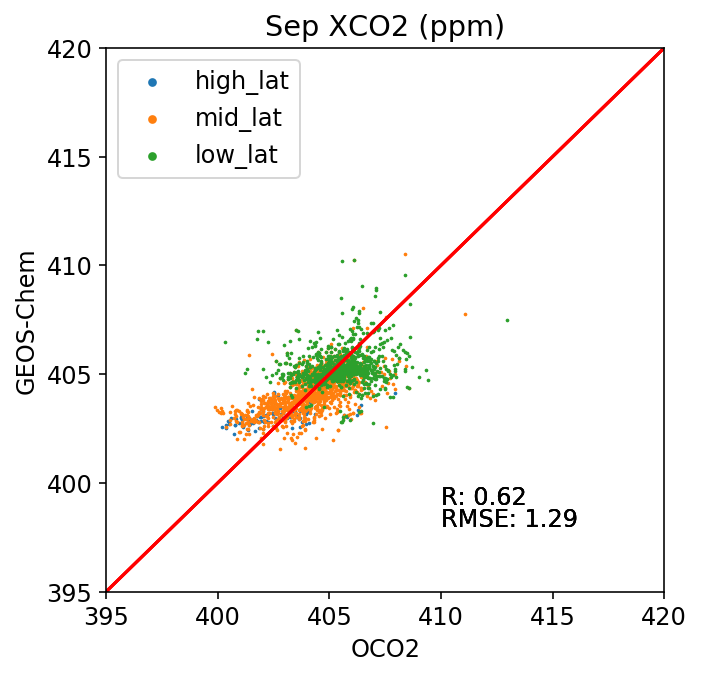

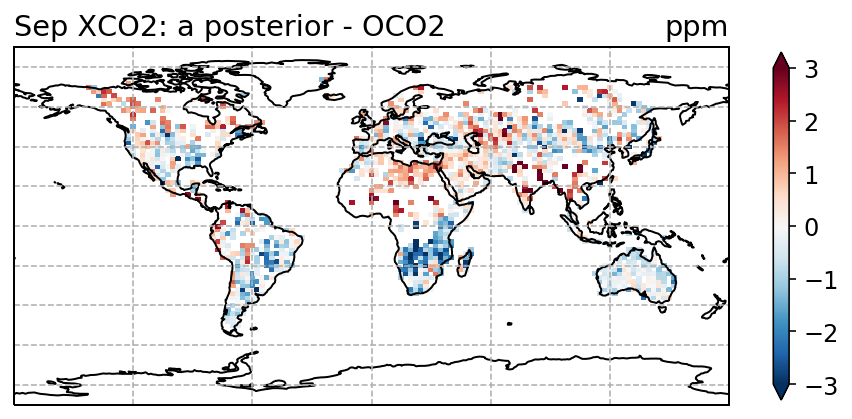

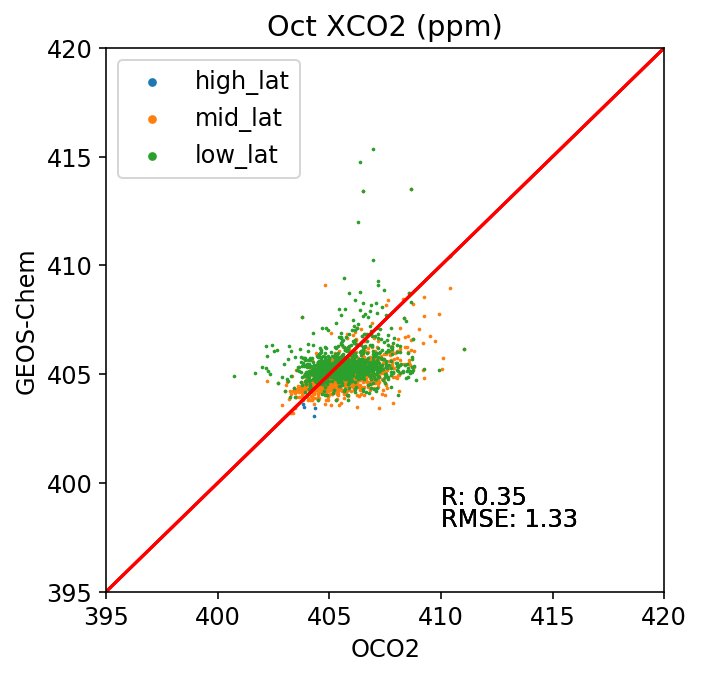

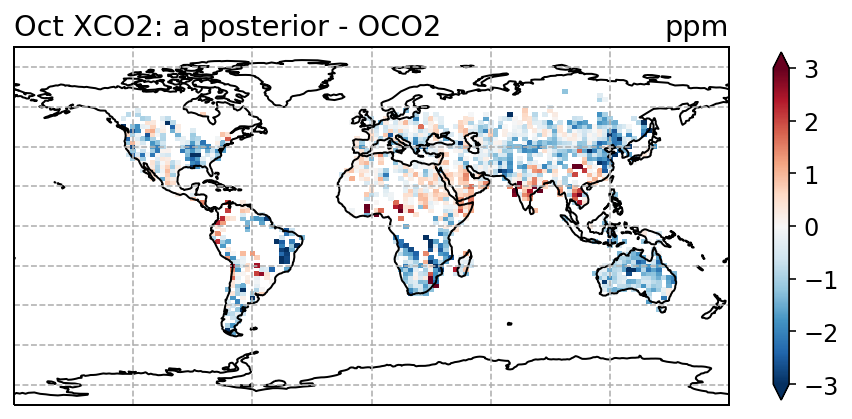

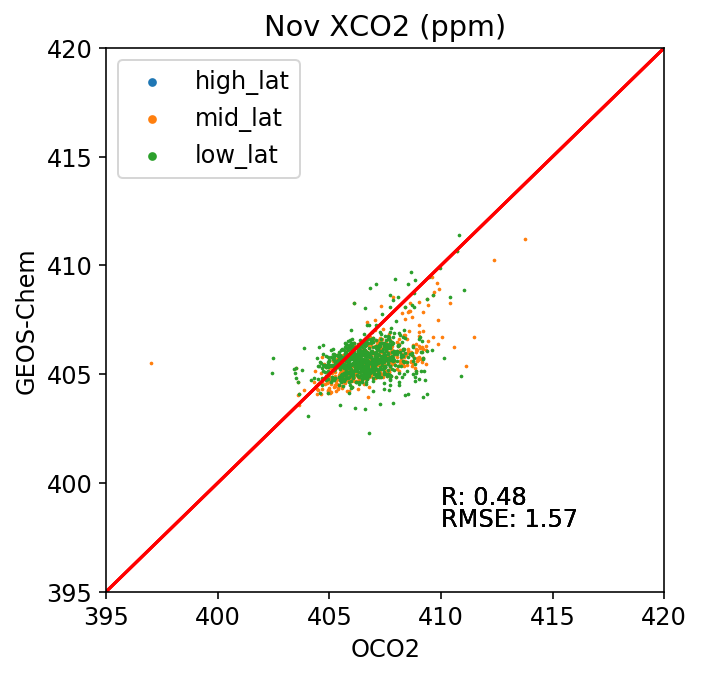

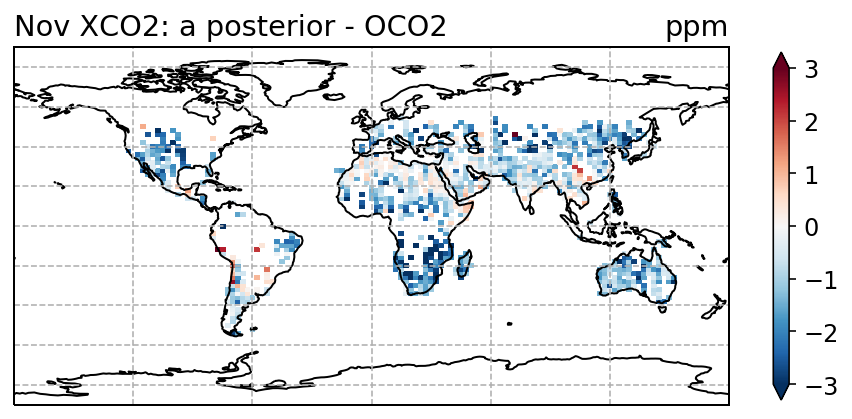

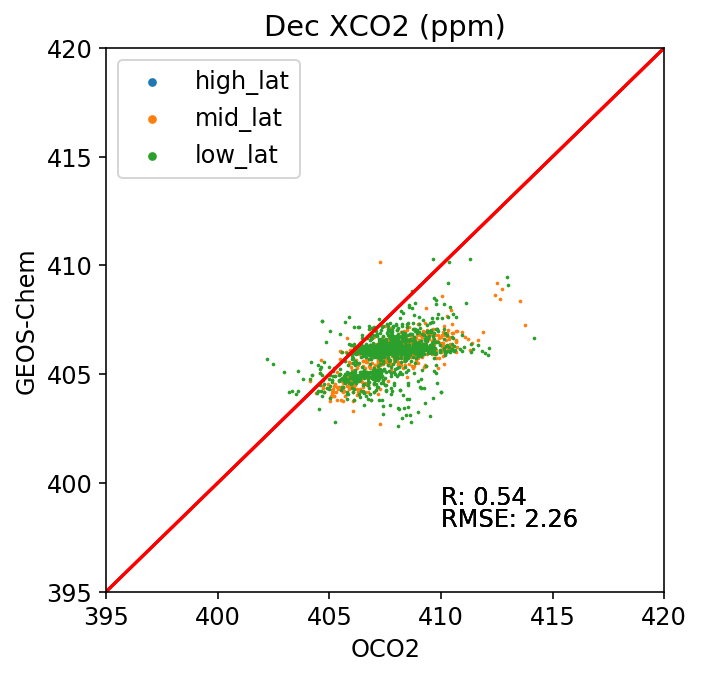

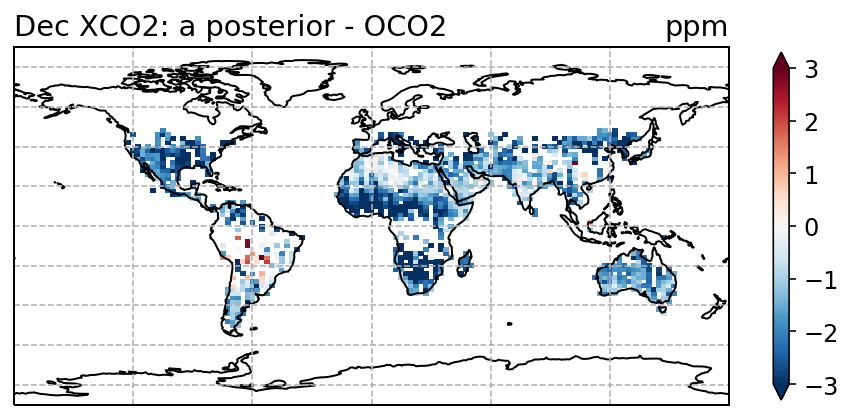

In [5]:
%%time

for imonth in range(assim_month-3,assim_month+1):
    compare_XCO2(mod_dir = mod_dir, 
                 sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                 year = year, 
                 month = imonth, 
                 str1_mod = 'interpolated_2d_ts_satellite.', 
                 str1_sat = '2d_OCO2_extract_',
                 mode = 'N')


In [ ]:
# improvement is too small